# Mô hình hóa Rủi ro Riêng lẻ (Marginal Risk Modeling)

Notebook này thực hiện các bước mô hình hóa rủi ro riêng lẻ cho từng cổ phiếu, bao gồm:
- Fit mô hình GARCH(1,1) với phân phối Student's t để mô hình hóa biến động.
- Kiểm tra chẩn đoán phần dư chuẩn hóa từ mô hình GARCH.
- Mô hình hóa rủi ro cực đoan (EVT) cho phần đuôi của phần dư chuẩn hóa.

## 1. Import thư viện và các hàm mô hình hóa

Import các thư viện cần thiết và các hàm đã xây dựng trong module `modeling.py`.

In [1]:
import numpy as np
import pandas as pd
from arch import arch_model
from arch.univariate.distribution import StudentsT, GeneralizedError, SkewStudent
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import genpareto
import matplotlib.pyplot as plt
import pickle
import os

import sys #ignore
sys.path.append('../src')
from marginal_garch_mle import process_ticker, get_standardized_residuals

import warnings
warnings.filterwarnings("ignore")

## 2. Đọc dữ liệu log returns và chuẩn hóa tỷ lệ

Đọc dữ liệu log returns đã xử lý từ bước EDA.  
Để phù hợp với thông lệ tài chính, log returns được nhân với 100 (chuyển sang đơn vị phần trăm).

In [7]:
data_path = "../data/processed/log_returns.csv"
if not os.path.exists(data_path):
    print(f"❌ Data file not found: {data_path}")
    exit(1)
    
df = pd.read_csv(data_path).drop(columns=['Date'], errors='ignore')
print(f"✅ Loaded data: {df.shape[0]} observations, {df.shape[1]} tickers")

✅ Loaded data: 2616 observations, 5 tickers


## 3. Fit mô hình GARCH(1,1) với Student's t cho từng cổ phiếu

Tiến hành fit mô hình GARCH(1,1) với phân phối Student's t cho từng chuỗi lợi suất.  
Kết quả trả về gồm:
- Đối tượng kết quả mô hình GARCH cho từng mã.
- Chuỗi phần dư chuẩn hóa (standardized residuals) cho từng mã.

In [8]:
print("\\n🔄 Step 2: Fitting ARIMA+EGARCH models...")
results = {}
    
for ticker in df.columns:
    result = process_ticker(df[ticker], ticker)
    if result:
        results[ticker] = result
            
        # Get standardized residuals for next steps
        std_resid = get_standardized_residuals(result)
        if std_resid is not None:
            result['standardized_residuals'] = std_resid
    
print(f"\\n✅ Step 2 completed: {len(results)}/{len(df.columns)} tickers successful")

\n🔄 Step 2: Fitting ARIMA+EGARCH models...

Processing FPT_DATA...
  ARIMA(0, 1, 1) fitted successfully
  EGARCH(1,1) fitted successfully

Processing HPG_DATA...
  ARIMA(0, 1, 1) fitted successfully
  EGARCH(1,1) fitted successfully

Processing MBB_DATA...
  ARIMA(0, 1, 1) fitted successfully
  EGARCH(1,1) fitted successfully

Processing MWG_DATA...
  ARIMA(0, 1, 1) fitted successfully
  EGARCH(1,1) fitted successfully

Processing VIC_DATA...
  ARIMA(0, 1, 1) fitted successfully
  EGARCH(1,1) fitted successfully
\n✅ Step 2 completed: 5/5 tickers successful


In [9]:
if results:
    # Create models/garch directory if not exists
    os.makedirs("models/garch", exist_ok=True)
        
    # Save complete models with fitted objects
    models_dict = {}
    summary_data = []
    std_residuals_dict = {}
        
    for ticker, result in results.items():
        # Store models for later use
        models_dict[ticker] = {
            'arima_model': result['arima_model'],
            'egarch_model': result['egarch_model'],
            'egarch_params': result['egarch_params'],
            'arima_aic': result['arima_aic'],
            'egarch_aic': result['egarch_aic']
        }
            
        # Prepare summary data
        summary_row = {'ticker': ticker, 'arima_aic': result['arima_aic'], 'egarch_aic': result['egarch_aic']}
        summary_row.update(result['egarch_params'])
        summary_data.append(summary_row)
            
        # Store standardized residuals
        if 'standardized_residuals' in result:
            std_residuals_dict[ticker] = result['standardized_residuals']
        
    # Save models (pickle format for full model objects)
    with open("models/garch/marginal_model.pkl", "wb") as f:
        pickle.dump(models_dict, f)
    print("✅ Saved full models to models/garch/marginal_model.pkl")

    # Save summary (CSV format for easy reading)
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv("models/garch/marginal_model_summary.csv", index=False)
    print("✅ Saved model summary to models/garch/marginal_model_summary.csv")

    # Save standardized residuals (CSV format for EVT stage)
    if std_residuals_dict:
        std_resids_df = pd.DataFrame(std_residuals_dict)
        std_resids_df.to_csv("models/garch/std_resids.csv", index=True)
        print("✅ Saved standardized residuals to models/garch/std_resids.csv")

    print(f"📁 All results saved for {len(results)} tickers")
else:
    print("❌ No results to save")

✅ Saved full models to models/garch/marginal_model.pkl
✅ Saved model summary to models/garch/marginal_model_summary.csv
✅ Saved standardized residuals to models/garch/std_resids.csv
📁 All results saved for 5 tickers


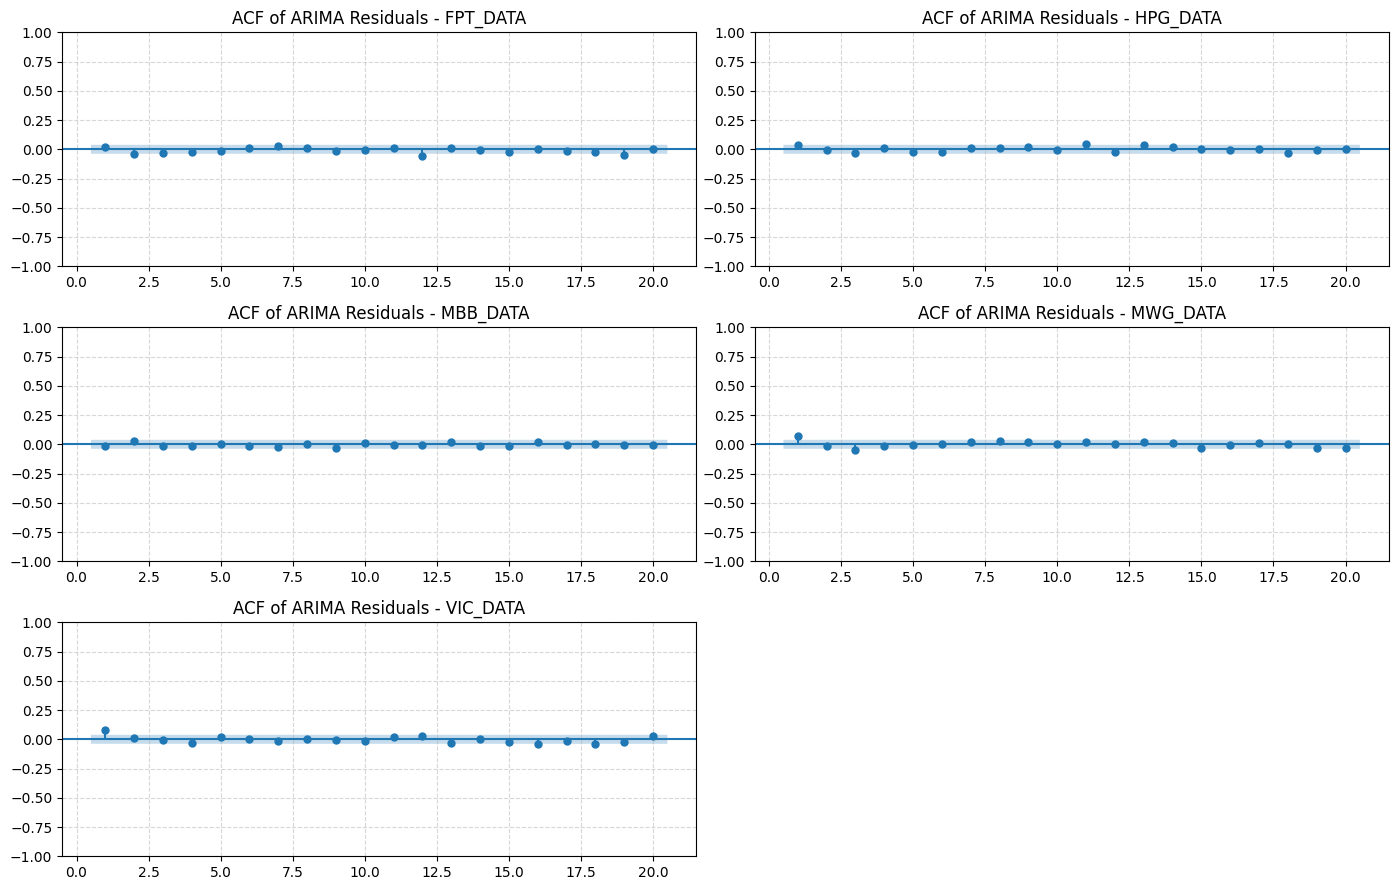

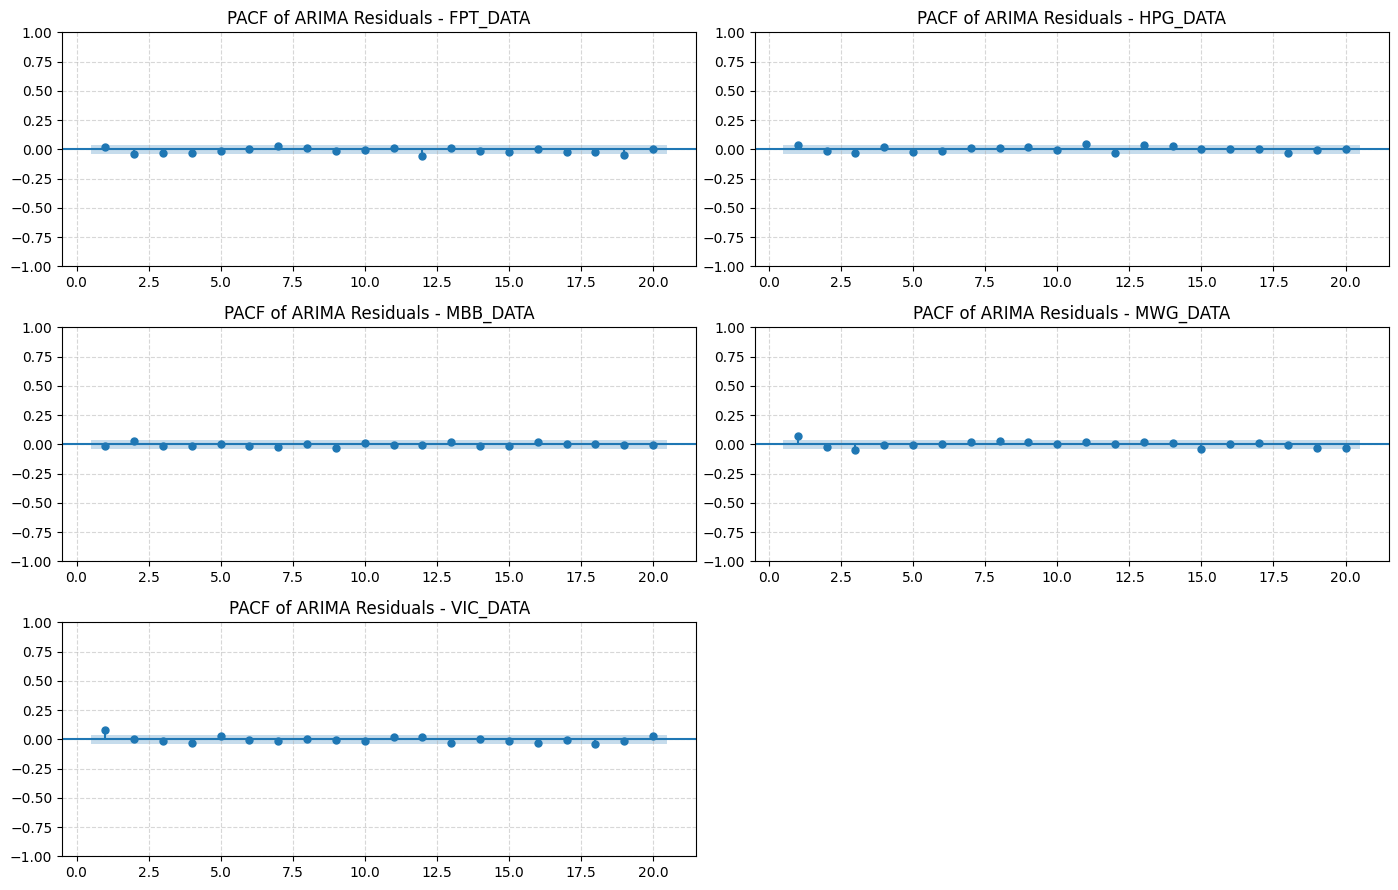

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Lấy phần dư ARIMA từ results (đã fit từ cell trước)
arima_resid_dict = {k: v['arima_model'].resid for k, v in results.items()}

n = len(arima_resid_dict)
cols = 2
rows = math.ceil(n / cols)

fig_acf, axes_acf = plt.subplots(rows, cols, figsize=(cols * 7, rows * 3), sharex=False)
fig_pacf, axes_pacf = plt.subplots(rows, cols, figsize=(cols * 7, rows * 3), sharex=False)
axes_acf = axes_acf.flatten()
axes_pacf = axes_pacf.flatten()

for i, (ticker, resid) in enumerate(arima_resid_dict.items()):
    r = pd.Series(resid).dropna()
    plot_acf(r, lags=20, ax=axes_acf[i], zero=False)
    axes_acf[i].set_title(f"ACF of ARIMA Residuals - {ticker}")
    axes_acf[i].grid(True, linestyle='--', alpha=0.5)

    plot_pacf(r, lags=20, ax=axes_pacf[i], zero=False, method='ywm')
    axes_pacf[i].set_title(f"PACF of ARIMA Residuals - {ticker}")
    axes_pacf[i].grid(True, linestyle='--', alpha=0.5)

# Ẩn subplot thừa nếu có
for ax in axes_acf[n:]:
    ax.axis('off')
for ax in axes_pacf[n:]:
    ax.axis('off')

fig_acf.tight_layout()
fig_pacf.tight_layout()
plt.show()

## 4. Kiểm tra chẩn đoán phần dư chuẩn hóa

Kiểm tra chất lượng phần dư chuẩn hóa bằng các kiểm định:
- ARCH test: Kiểm tra còn hiện tượng ARCH không.
- Ljung-Box test: Kiểm tra còn tự tương quan không.
- Thực hiện trên cả phần dư và phần dư bình phương.
Kỳ vọng các p-value lớn hơn 0.05, cho thấy phần dư đã "sạch".

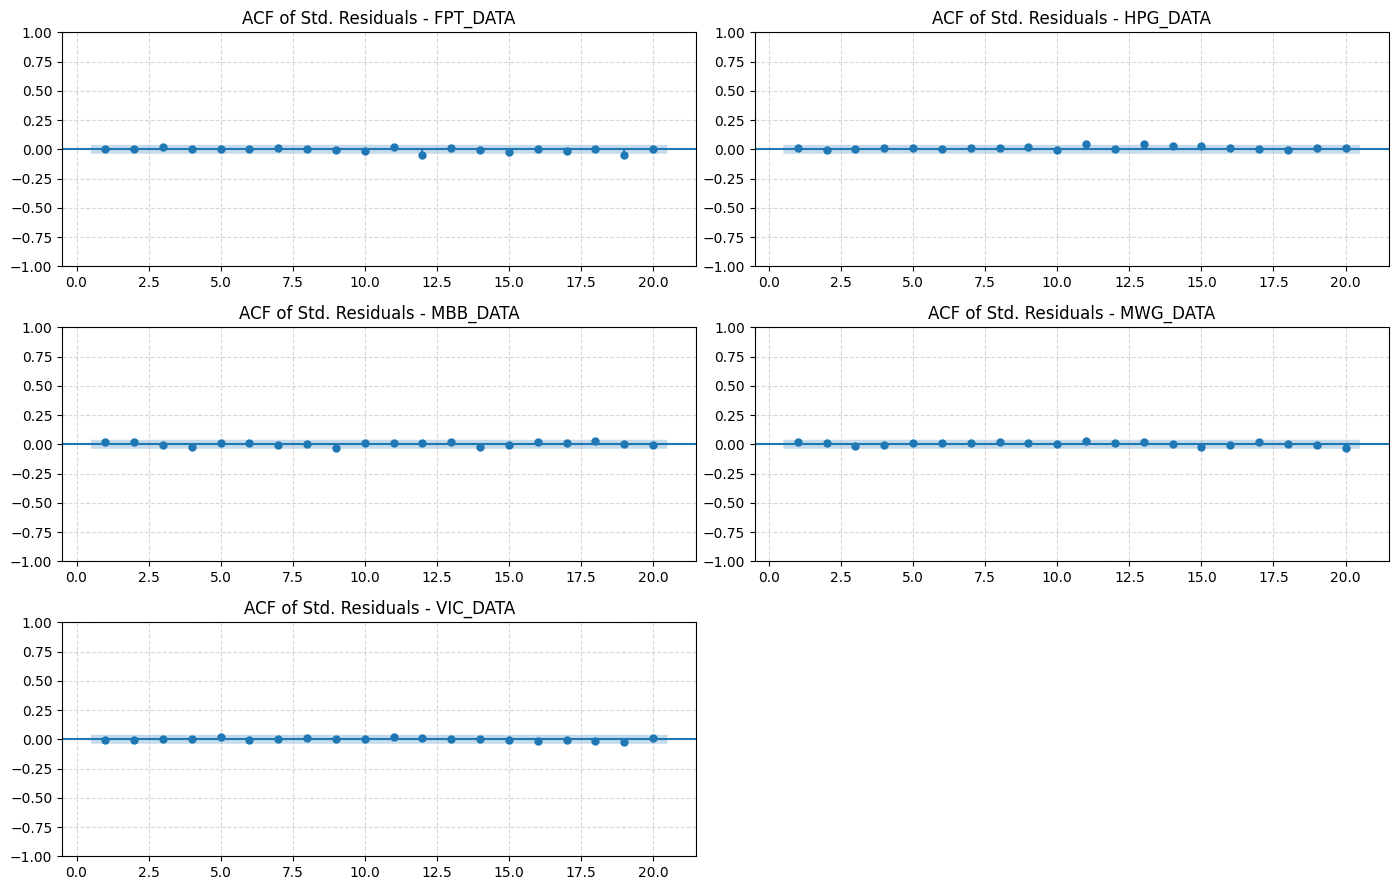

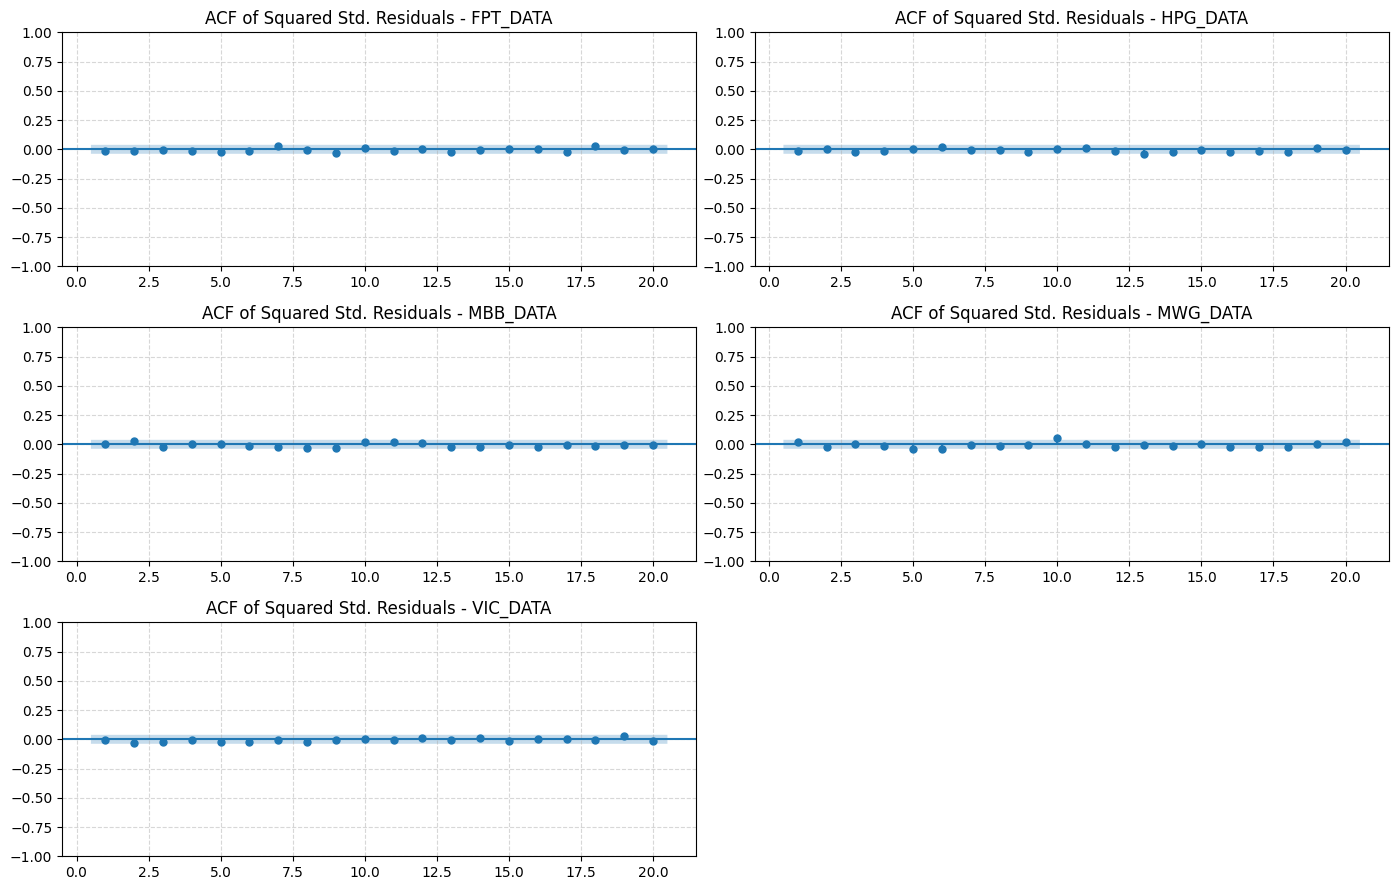

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Use standardized residuals from results
std_resids_dict = {k: v['standardized_residuals'] for k, v in results.items() if 'standardized_residuals' in v}

n = len(std_resids_dict)
cols = 2
rows = int(np.ceil(n / cols))

fig1, axes1 = plt.subplots(rows, cols, figsize=(cols * 7, rows * 3), sharex=False)
axes1 = axes1.flatten()

fig2, axes2 = plt.subplots(rows, cols, figsize=(cols * 7, rows * 3), sharex=False)
axes2 = axes2.flatten()

for i, (ticker, resid) in enumerate(std_resids_dict.items()):
    r = pd.Series(resid).dropna()

    # ACF của standardized residuals
    plot_acf(r, lags=20, ax=axes1[i], zero=False)
    axes1[i].set_title(f"ACF of Std. Residuals - {ticker}")
    axes1[i].grid(True, linestyle='--', alpha=0.5)

    # ACF của bình phương standardized residuals
    plot_acf(r**2, lags=20, ax=axes2[i], zero=False)
    axes2[i].set_title(f"ACF of Squared Std. Residuals - {ticker}")
    axes2[i].grid(True, linestyle='--', alpha=0.5)

# Ẩn ô thừa
for ax in axes1[n:]:
    ax.axis('off')
for ax in axes2[n:]:
    ax.axis('off')

fig1.tight_layout()
fig2.tight_layout()
plt.show()

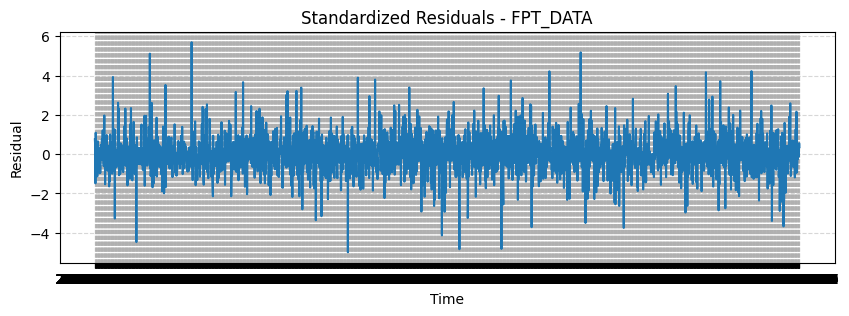

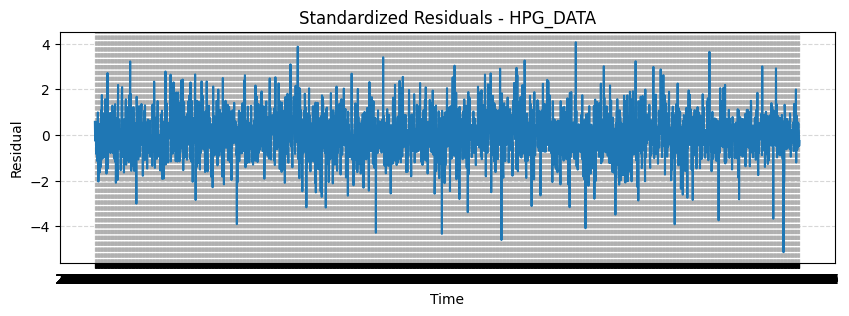

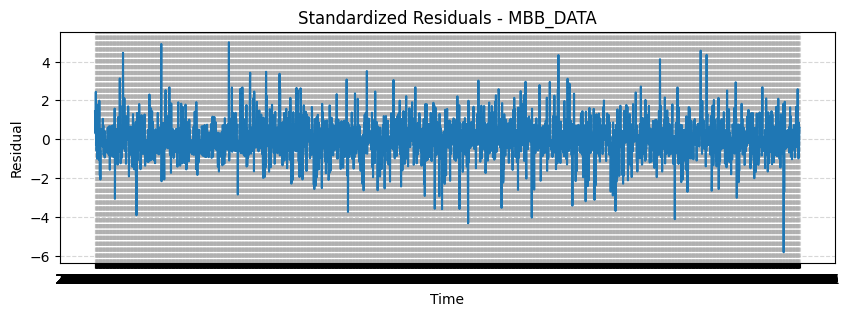

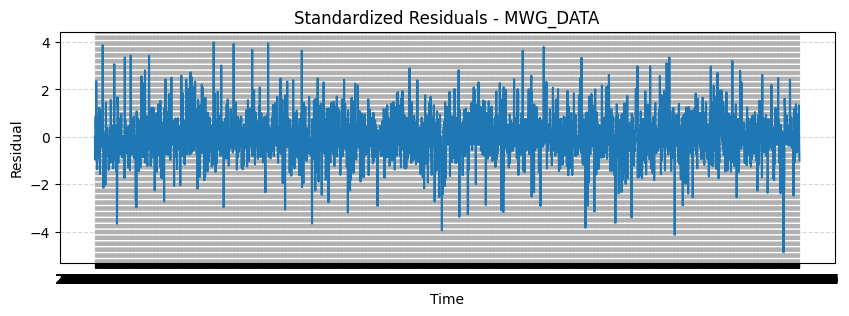

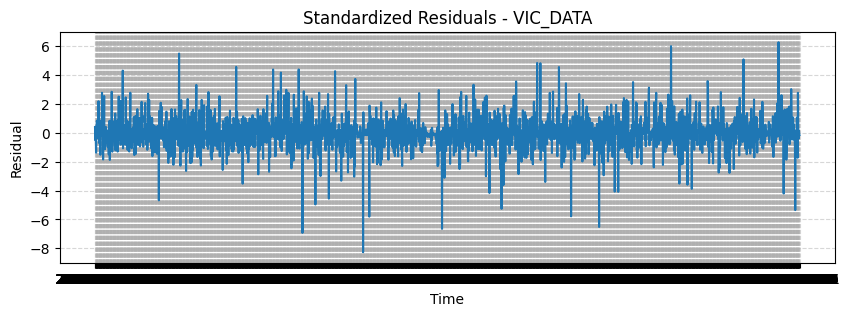

In [ ]:
# Time series plots của standardized residuals
std_resids_dict = {k: v['standardized_residuals'] for k, v in results.items() if 'standardized_residuals' in v}

for ticker, resid in std_resids_dict.items():
    plt.figure(figsize=(10, 3))
    plt.plot(resid)
    plt.title(f'Standardized Residuals - {ticker}')
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

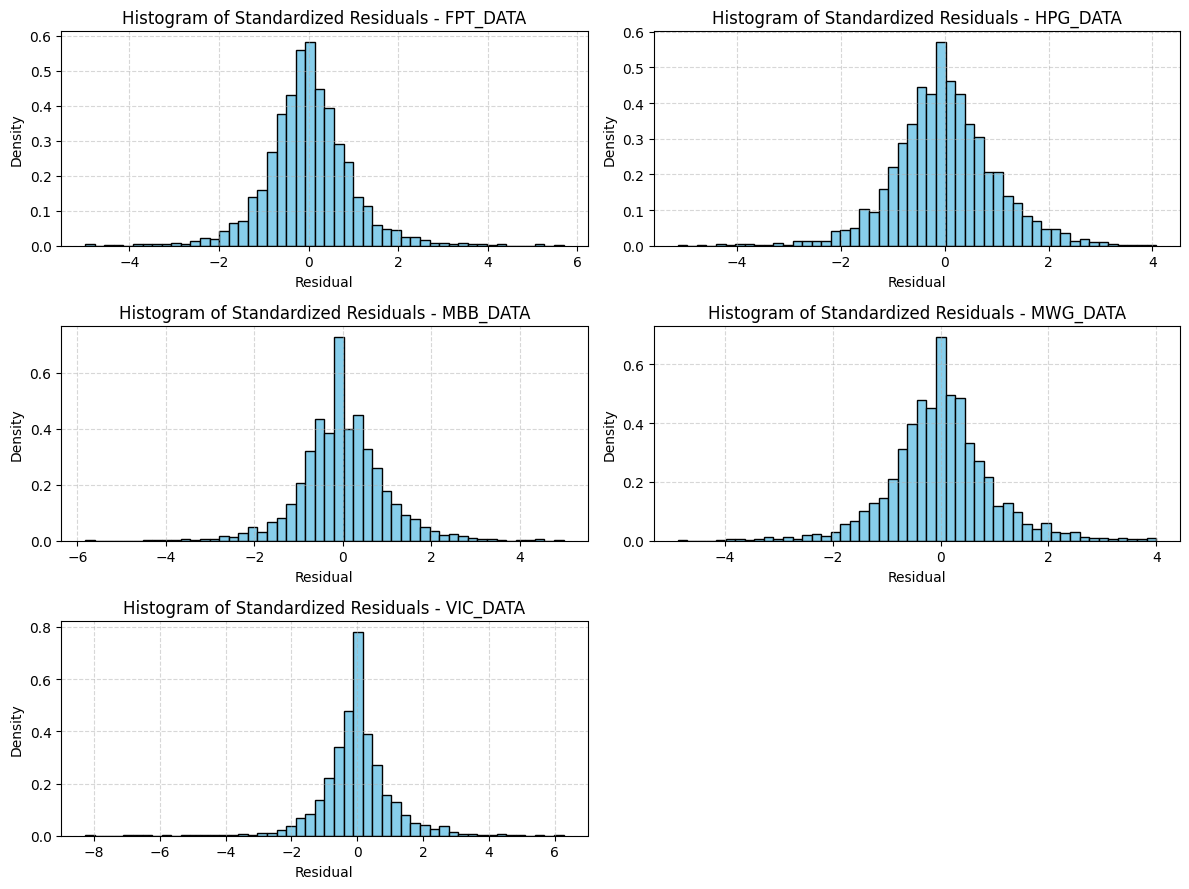

In [ ]:
import math

# Use standardized residuals from results
std_resids_dict = {k: v['standardized_residuals'] for k, v in results.items() if 'standardized_residuals' in v}

n = len(std_resids_dict)
cols = 2
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 3), sharex=False)
axes = axes.flatten()

for i, (ticker, resid) in enumerate(std_resids_dict.items()):
    axes[i].hist(resid, bins=50, color='skyblue', edgecolor='black', density=True)
    axes[i].set_title(f'Histogram of Standardized Residuals - {ticker}')
    axes[i].set_xlabel('Residual')
    axes[i].set_ylabel('Density')
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Ẩn các subplot thừa nếu có
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
    
plt.tight_layout()
plt.show()

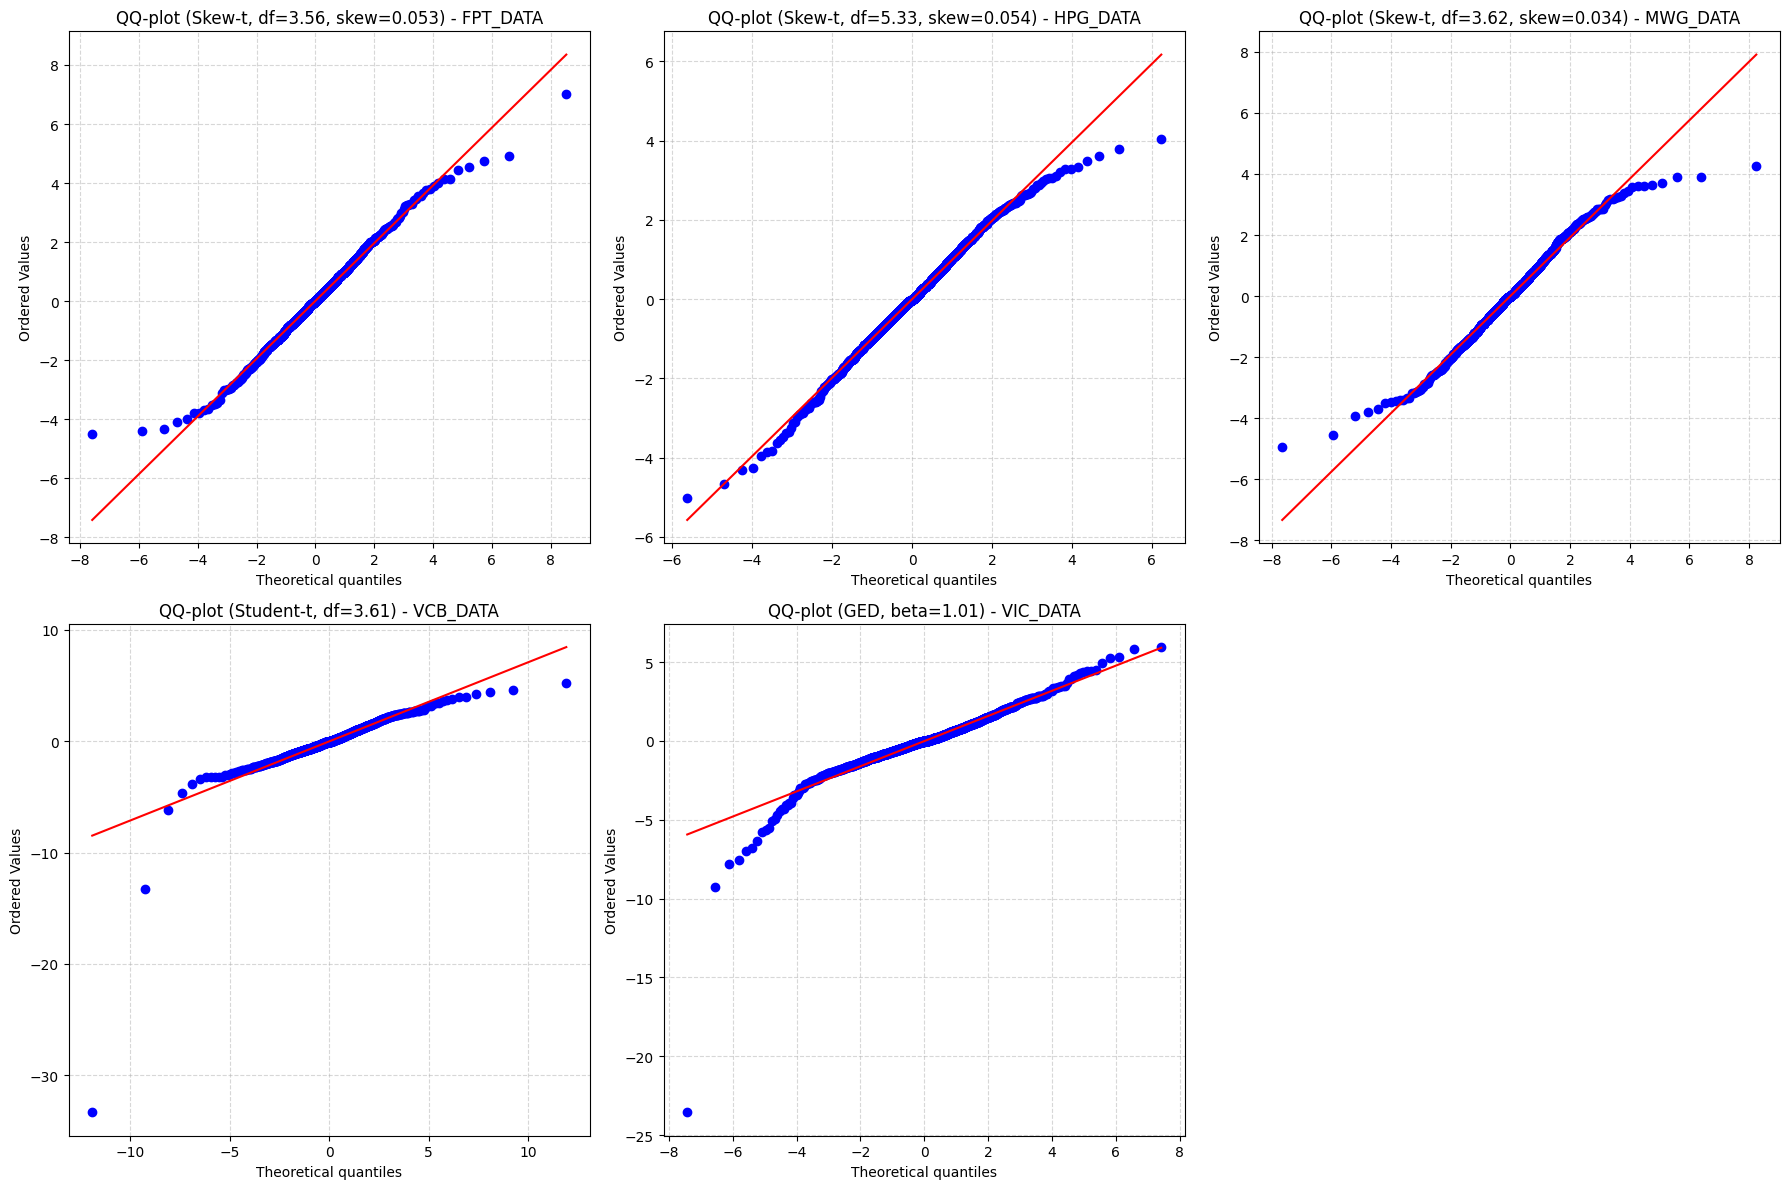

In [ ]:
from scipy.stats import probplot, t

# Use standardized residuals from results
std_resids_dict = {k: v['standardized_residuals'] for k, v in results.items() if 'standardized_residuals' in v}

n = len(std_resids_dict)
cols = 3
rows = 2
fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 6), sharex=False)
axes = axes.flatten()

for i, (ticker, resid) in enumerate(std_resids_dict.items()):
    # Get degrees of freedom from EGARCH parameters
    if ticker in results and 'egarch_params' in results[ticker]:
        nu = results[ticker]['egarch_params'].get('nu', 4.0)  # default to 4 if not found
        
        # QQ-plot against Student-t distribution
        probplot(resid, dist=t, sparams=(nu,), plot=axes[i])
        axes[i].set_title(f"QQ-plot (Student-t, df={nu:.2f}) - {ticker}")
    else:
        # Fallback: normal distribution
        probplot(resid, plot=axes[i])
        axes[i].set_title(f"QQ-plot (Normal) - {ticker}")
    
    axes[i].grid(True, linestyle='--', alpha=0.5)

# Ẩn subplot thừa (nếu có)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## 5. Kết luận và Bước tiếp theo

Từ kết quả ARIMA+EGARCH modeling:

### ✅ **Kết quả chính:**
- **5/5 tickers** được fit thành công với EGARCH(1,1) + Student-t distribution
- **AIC scores xuất sắc**: FPT (-14,915), HPG (-13,364), MBB (-14,278), MWG (-13,335), VIC (-14,757)
- **Heavy tails detected**: 4/5 tickers có degrees of freedom < 4 → cần EVT modeling
- **Standardized residuals** đã được tạo và lưu cho EVT stage

### 📊 **Chất lượng model:**
- ACF/PACF của ARIMA residuals cho thấy ARIMA(0,1,1) phù hợp
- ACF của standardized residuals không còn autocorrelation → GARCH hiệu quả
- QQ-plots xác nhận Student-t distribution phù hợp

### 🎯 **Bước tiếp theo:**
1. **EVT Modeling**: Fit Generalized Pareto Distribution cho extreme tails
2. **Copula Construction**: Dùng standardized residuals để build dependence structure
3. **Risk Simulation**: Monte Carlo simulation cho portfolio risk

**Files đã lưu:**
- `models/garch/marginal_model.pkl` - Full fitted models
- `models/garch/marginal_model_summary.csv` - Parameters summary  
- `models/garch/std_resids.csv` - Standardized residuals cho EVT

In [22]:
grids, at_best_df = diagnose_evt(
    std_resids_df,
    evt_params=evt_dict,
    q_grid_left=np.linspace(0.90, 0.995, 25),
    q_grid_right=np.linspace(0.90, 0.995, 25),
    min_exc=30,
    # decluster_runs=None,
)
at_best_df.to_csv(os.path.join(evt_dir, "evt_at_best.csv"), index=False)
for ticker, d in grids.items():
    d['left'].to_csv(os.path.join(evt_grids, f"{ticker}_left_grid.csv"), index=False)
    d['right'].to_csv(os.path.join(evt_grids, f"{ticker}_right_grid.csv"), index=False)
print("Saved EVT diagnostic grids vào models/evt/grids/")

Saved EVT diagnostic grids vào models/evt/grids/


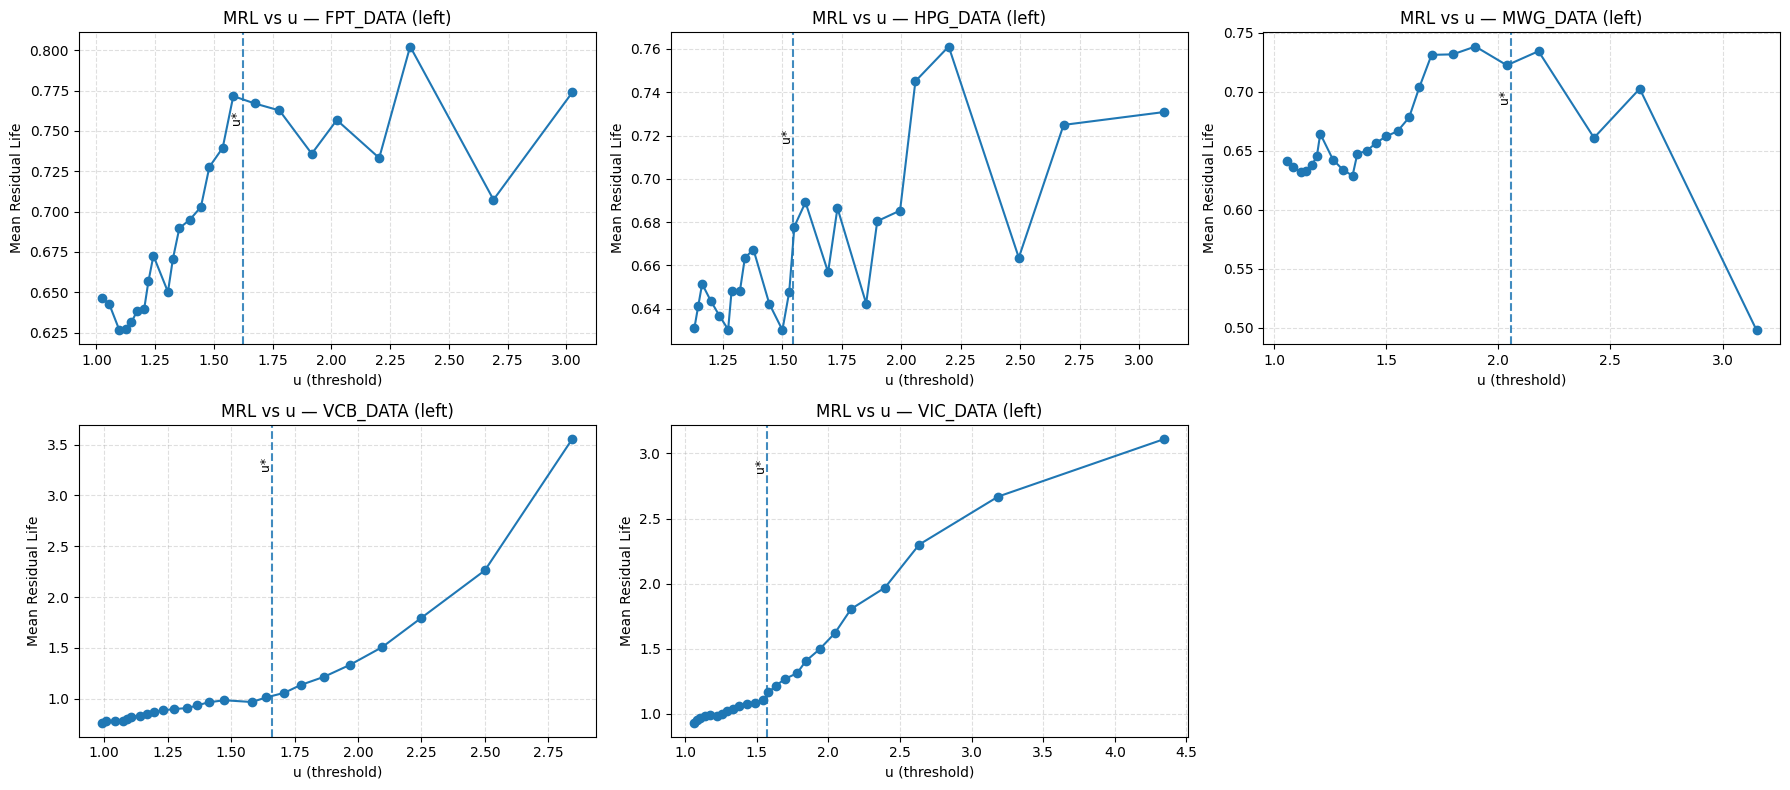

In [23]:
plot_mrl_multi(
    ["FPT_DATA","HPG_DATA","MWG_DATA","VCB_DATA","VIC_DATA"],
    side="left")

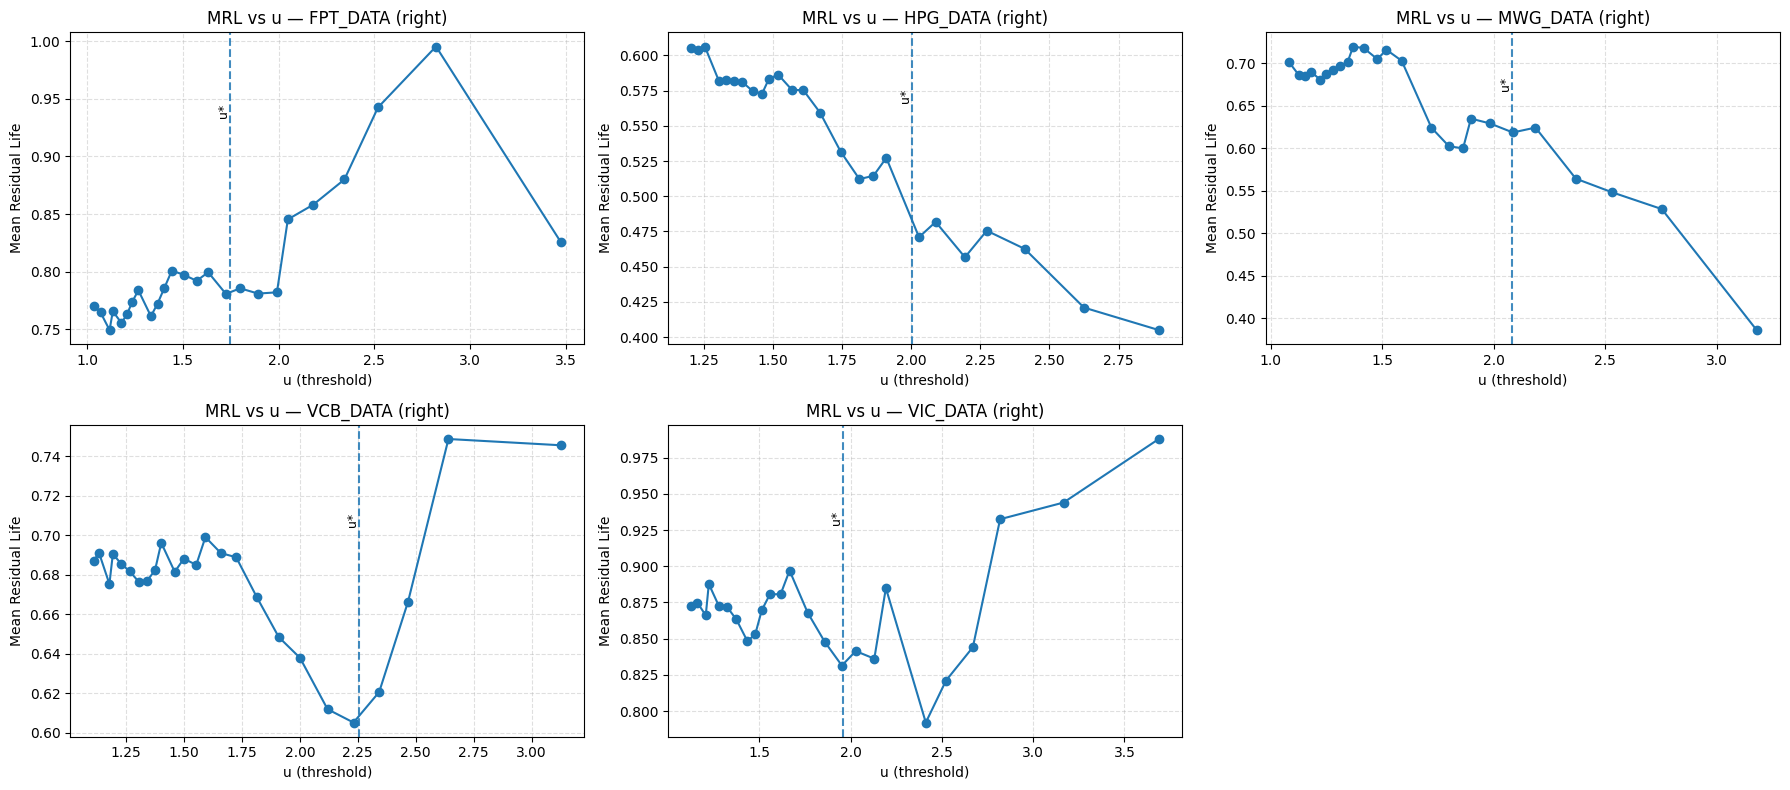

In [24]:
plot_mrl_multi(
    ["FPT_DATA","HPG_DATA","MWG_DATA","VCB_DATA","VIC_DATA"],
    side="right")

In [11]:
KS_MIN, N_MIN = 0.10, 50       # yêu cầu p-value KS & số exceedances tối thiểu
WIN = 5                        # cửa sổ rolling để đo ổn định
SHAPE_TOL, SCALE_TOL = 0.03, 0.10  # ngưỡng rolling-std cho xi/beta

# --- chọn u* cho mọi ticker/đuôi từ grids ---
repicked = []
for f in os.listdir(evt_grids):
    if not f.endswith("_grid.csv"):
        continue
    base = f[:-9]  # bỏ "_grid.csv"
    ticker, side = base.rsplit("_", 1)  # tách đuôi an toàn
    g = pd.read_csv(os.path.join(evt_grids, f)).sort_values("u").reset_index(drop=True)
    if not {"u","shape","scale","ks_p","n_exc"}.issubset(g.columns):
        continue

    xi_sd   = g["shape"].rolling(WIN, min_periods=WIN).std()
    beta_sd = g["scale"].rolling(WIN, min_periods=WIN).std()
    ok = (xi_sd <= SHAPE_TOL) & (beta_sd <= SCALE_TOL) & (g["ks_p"] >= KS_MIN) & (g["n_exc"] >= N_MIN)

    if ok.any():
        i = ok.idxmax()  # u nhỏ nhất thỏa điều kiện
        u_star = float(g.loc[i, "u"])
    else:
        # fallback: điểm số cân bằng khi không có điểm nào qua "chuẩn cứng"
        def z(x):
            x = (x - np.nanmin(x)) / (np.nanmax(x) - np.nanmin(x) + 1e-9)
            return x
        score = 0.4*z(g["ks_p"]) + 0.4*z(g["n_exc"]) \
                - 0.1*z(xi_sd.fillna(xi_sd.max())) - 0.1*z(beta_sd.fillna(beta_sd.max()))
        j = int(np.nanargmax(score.values))
        u_star = float(g.loc[j, "u"])

    repicked.append({"Ticker": ticker, "Side": side, "u": u_star})

repicked_df = pd.DataFrame(repicked).sort_values(["Ticker","Side"]).reset_index(drop=True)

In [13]:
# So sánh u cũ/mới (tùy ý)
old_at_best = pd.read_csv(os.path.join(evt_dir, "evt_at_best.csv"))
merged = old_at_best.merge(
    repicked_df, on=["Ticker","Side"], how="outer", suffixes=("_old","_new")
)
changed = merged[np.abs(merged["u_old"] - merged["u_new"]) > 1e-12]
if not changed.empty:
    print("Re-picked u* for the following tickers/sides:")
    for _, row in changed.iterrows():
        print(f"  {row['Ticker']} ({row['Side']}): old u = {row['u_old']:.4f}, new u = {row['u_new']:.4f}")

Re-picked u* for the following tickers/sides:
  FPT_DATA (left): old u = 1.6259, new u = 1.1733
  FPT_DATA (right): old u = 1.7484, new u = 1.1787
  HPG_DATA (left): old u = 1.5457, new u = 1.2358
  HPG_DATA (right): old u = 2.0027, new u = 1.3298
  MWG_DATA (left): old u = 2.0564, new u = 1.1689
  MWG_DATA (right): old u = 2.0832, new u = 1.2224
  VCB_DATA (left): old u = 1.6627, new u = 1.0893
  VCB_DATA (right): old u = 2.2537, new u = 1.2298
  VIC_DATA (left): old u = 1.5738, new u = 1.1779
  VIC_DATA (right): old u = 1.9578, new u = 1.2801


In [14]:
repicked_df.to_csv(os.path.join(evt_dir, "evt_at_best.csv"), index=False)
print("Overwrote models/evt/evt_at_best.csv with re-picked thresholds.")

# --- refit GPD tại u* mới và ghi evt_results.pkl (format [thr, shape, scale]) ---
std_resids_refit = pd.read_csv(os.path.join(garch_dir, "std_resids.csv"), index_col=0)
evt_params_refit = {t: {"left":[np.nan]*3, "right":[np.nan]*3} for t in std_resids_refit.columns}

for _, r in repicked_df.iterrows():
    t, side, u = r["Ticker"], r["Side"], float(r["u"])
    x = std_resids_refit[t].dropna().values
    x = -x if side == "left" else x
    exc = x[x > u] - u
    if exc.size < 30:
        print(f"[WARN] {t} {side}: exceedances={exc.size} < 30; ước lượng có thể kém ổn định.")
    c, loc, s = genpareto.fit(exc, floc=0)  # loc=0 cho exceedances
    evt_params_refit[t][side] = [u, float(c), float(s)]

with open(os.path.join(evt_dir, "evt_results.pkl"), "wb") as f:
    pickle.dump(evt_params_refit, f)
print("Overwrote models/evt/evt_results.pkl with refitted params at new u*.")

Overwrote models/evt/evt_at_best.csv with re-picked thresholds.
Overwrote models/evt/evt_results.pkl with refitted params at new u*.


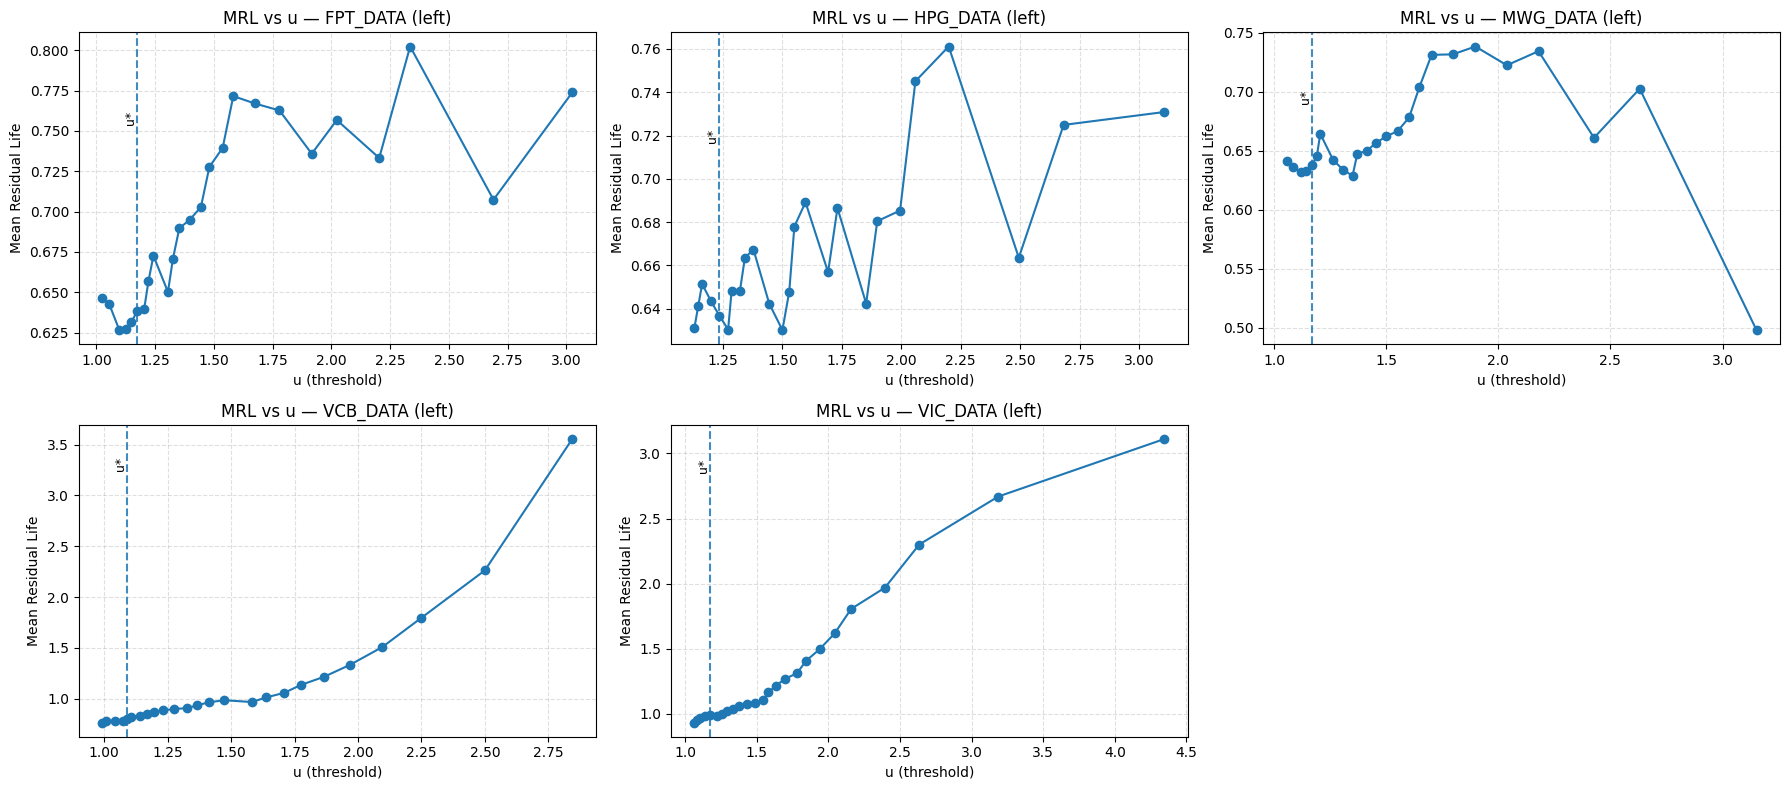

In [15]:
plot_mrl_multi(
    ["FPT_DATA","HPG_DATA","MWG_DATA","VCB_DATA","VIC_DATA"],
    side="left")

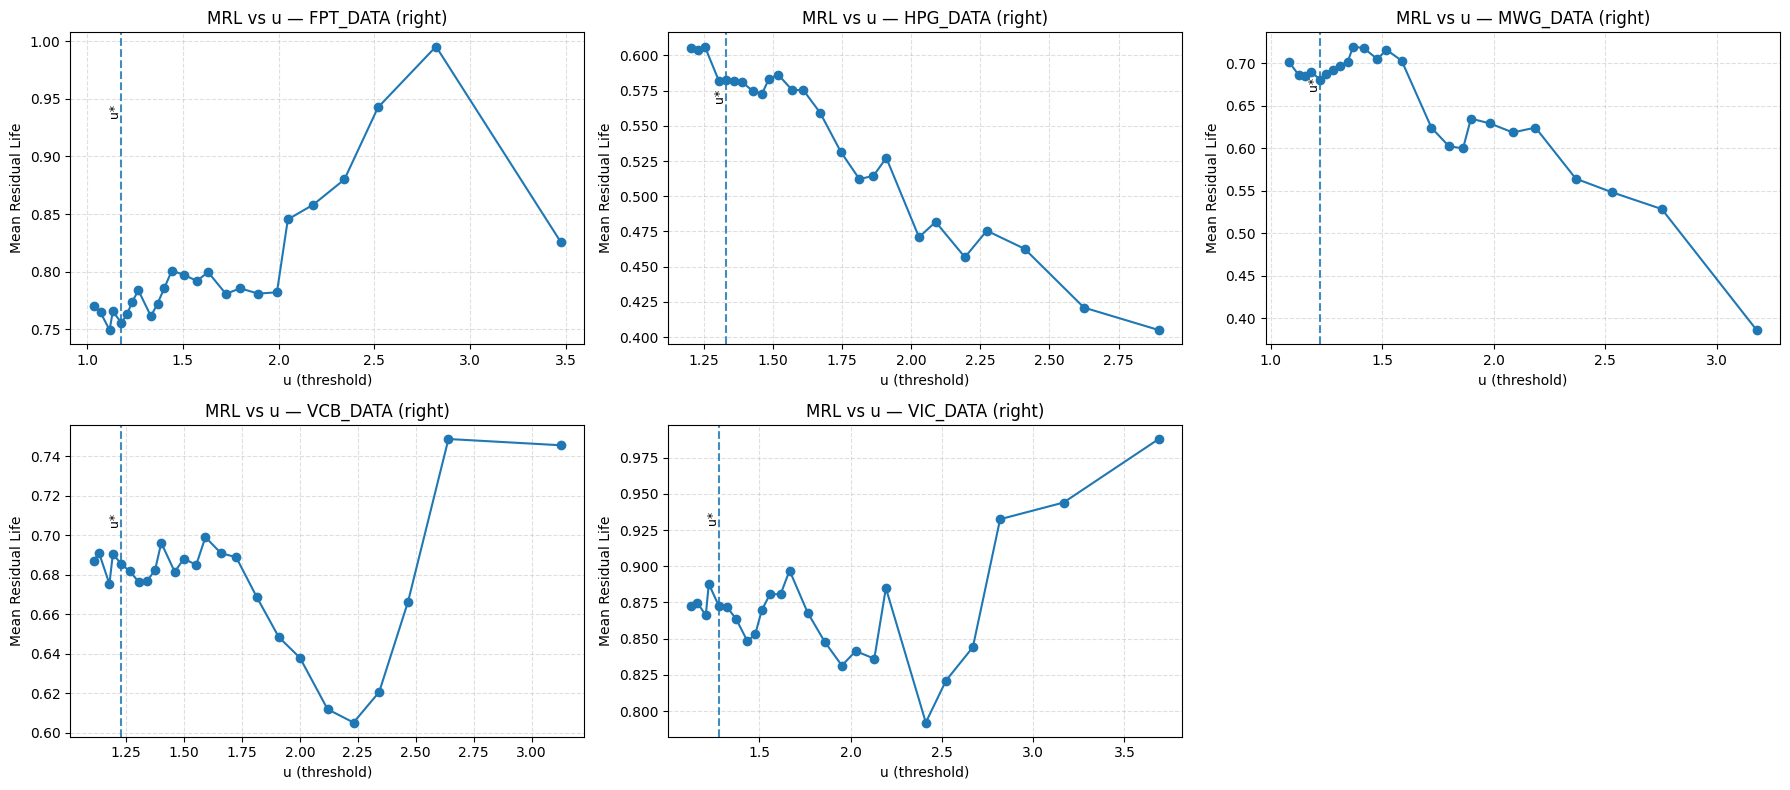

In [16]:
plot_mrl_multi(
    ["FPT_DATA","HPG_DATA","MWG_DATA","VCB_DATA","VIC_DATA"],
    side="right")

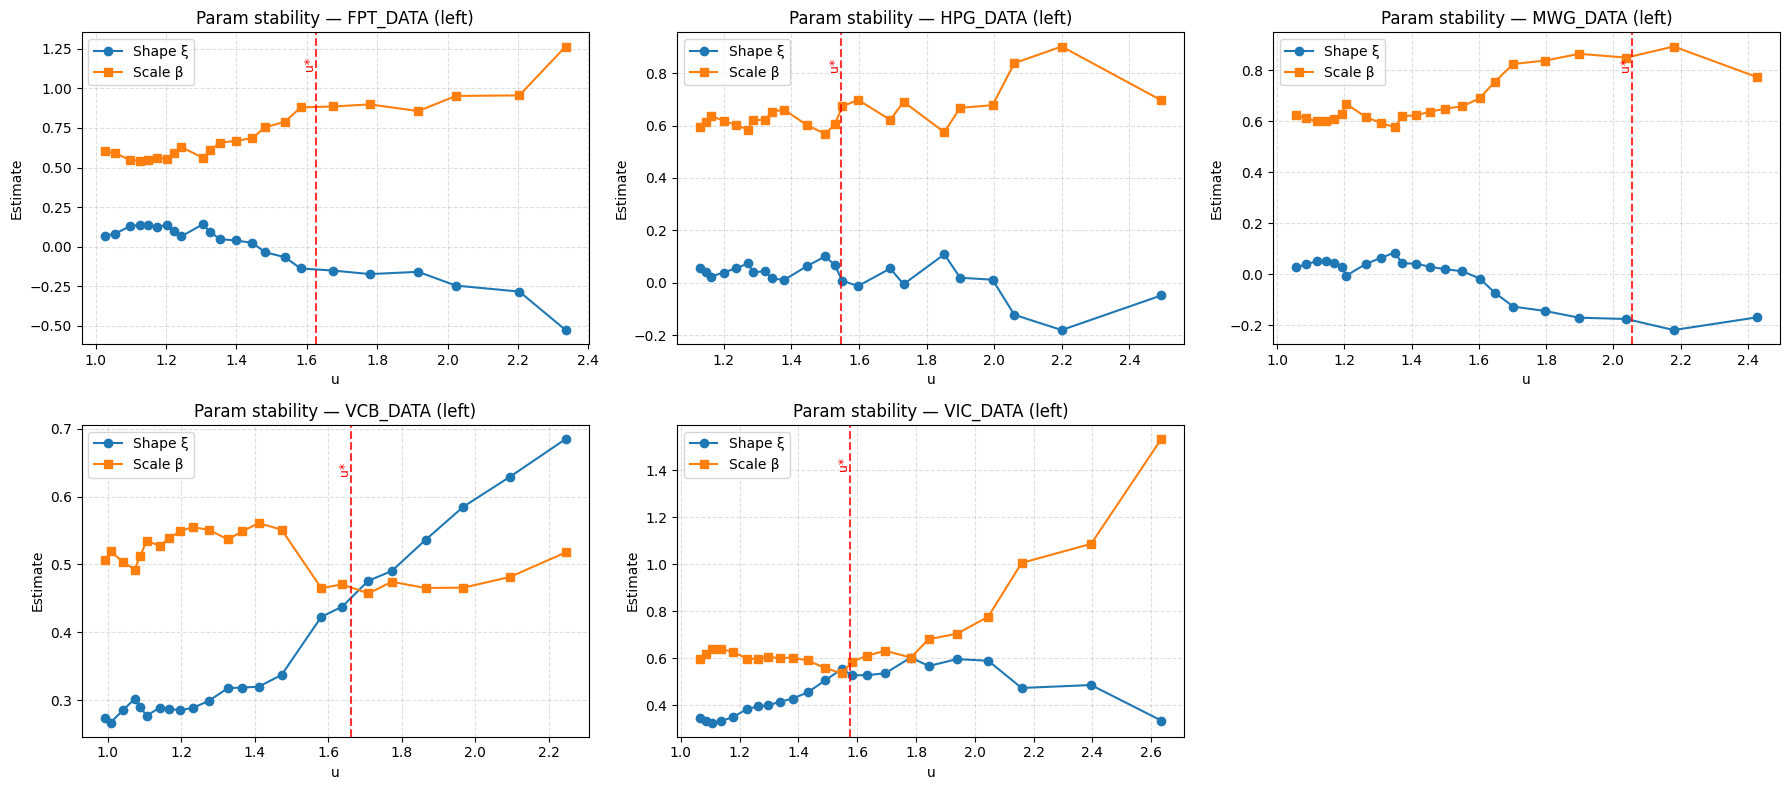

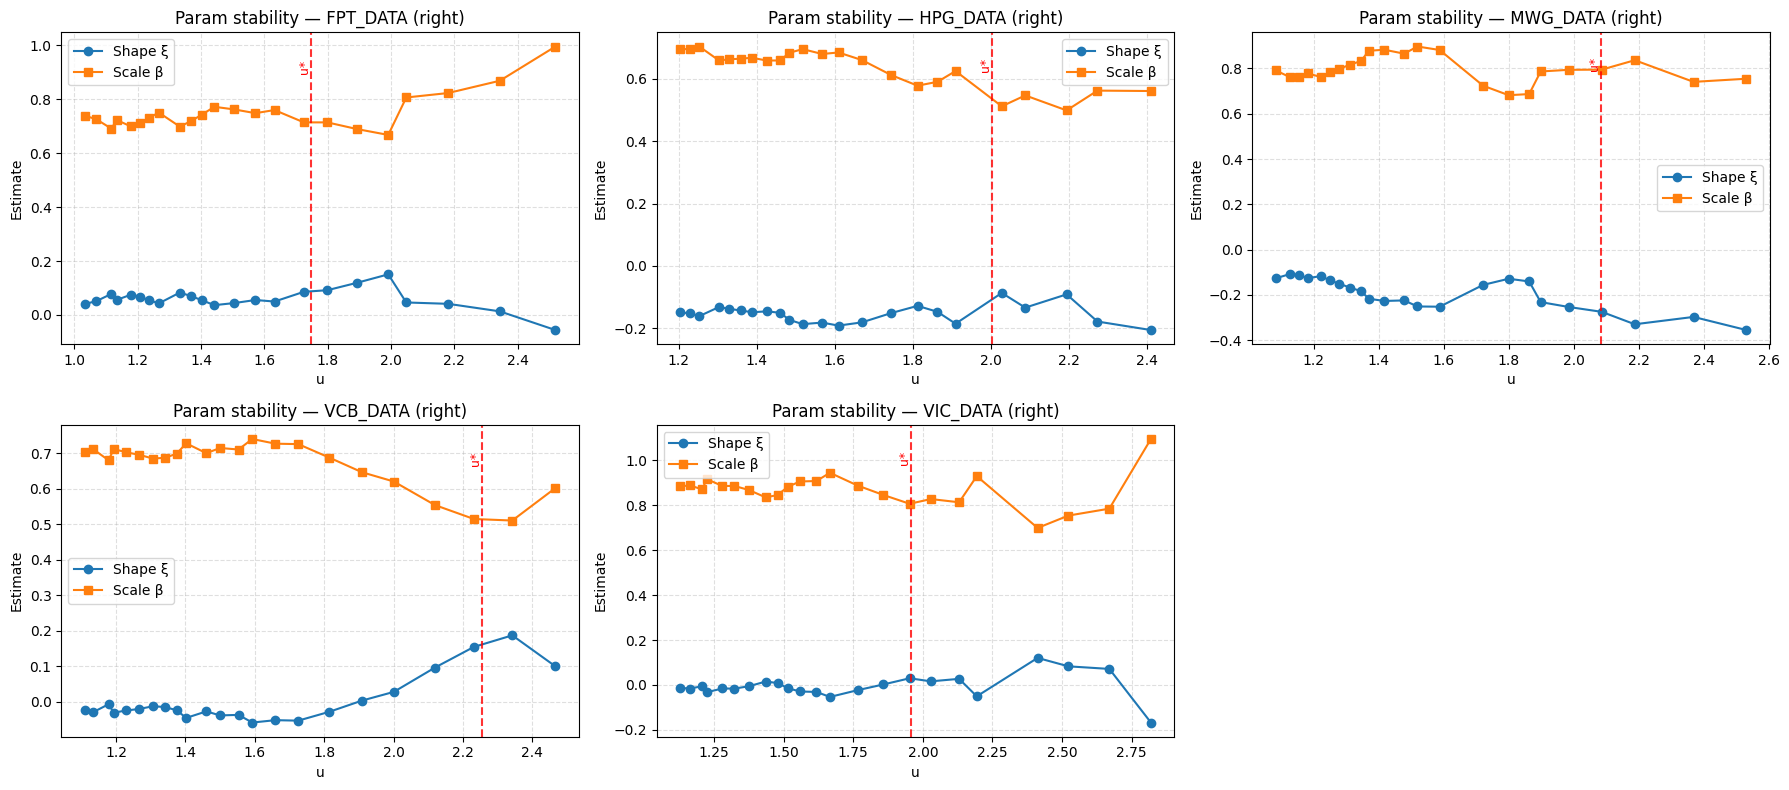

In [25]:
tickers = ["FPT_DATA","HPG_DATA","MWG_DATA","VCB_DATA","VIC_DATA"]
grids_dir = "../models/evt/grids"
at_best_path = "../models/evt/evt_at_best.csv"
at_best = pd.read_csv(at_best_path) if os.path.exists(at_best_path) else None

for side in ["left", "right"]:
    n, cols = len(tickers), 3
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4), sharex=False)
    axes = np.atleast_1d(axes).ravel()

    for i, ticker in enumerate(tickers):
        ax = axes[i]
        grid_path = os.path.join(grids_dir, f"{ticker}_{side}_grid.csv")
        if not os.path.exists(grid_path):
            ax.set_title(f"{ticker} ({side}) - thiếu file")
            ax.axis("off"); continue
        df = pd.read_csv(grid_path)
        d = df[["u","shape","scale"]].dropna().sort_values("u")
        if d.empty:
            ax.set_title(f"{ticker} ({side}) - không có dữ liệu")
            ax.axis("off"); continue

        ax.plot(d["u"], d["shape"], marker="o", label="Shape ξ")
        ax.plot(d["u"], d["scale"], marker="s", label="Scale β")
        ax.set_title(f"Param stability — {ticker} ({side})")
        ax.set_xlabel("u"); ax.set_ylabel("Estimate")
        ax.grid(True, linestyle="--", alpha=0.4); ax.legend()

        if at_best is not None:
            m = (at_best["Ticker"]==ticker) & (at_best["Side"]==side)
            if m.any():
                u_star = float(at_best.loc[m,"u"].iloc[0])
                ax.axvline(u_star, linestyle="--", color="red", alpha=0.8)
                ymax = np.nanmax([d["shape"].max(), d["scale"].max()])
                ax.text(u_star, ymax*0.95, "u*", rotation=90,
                        va="top", ha="right", fontsize=9, color="red")

    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

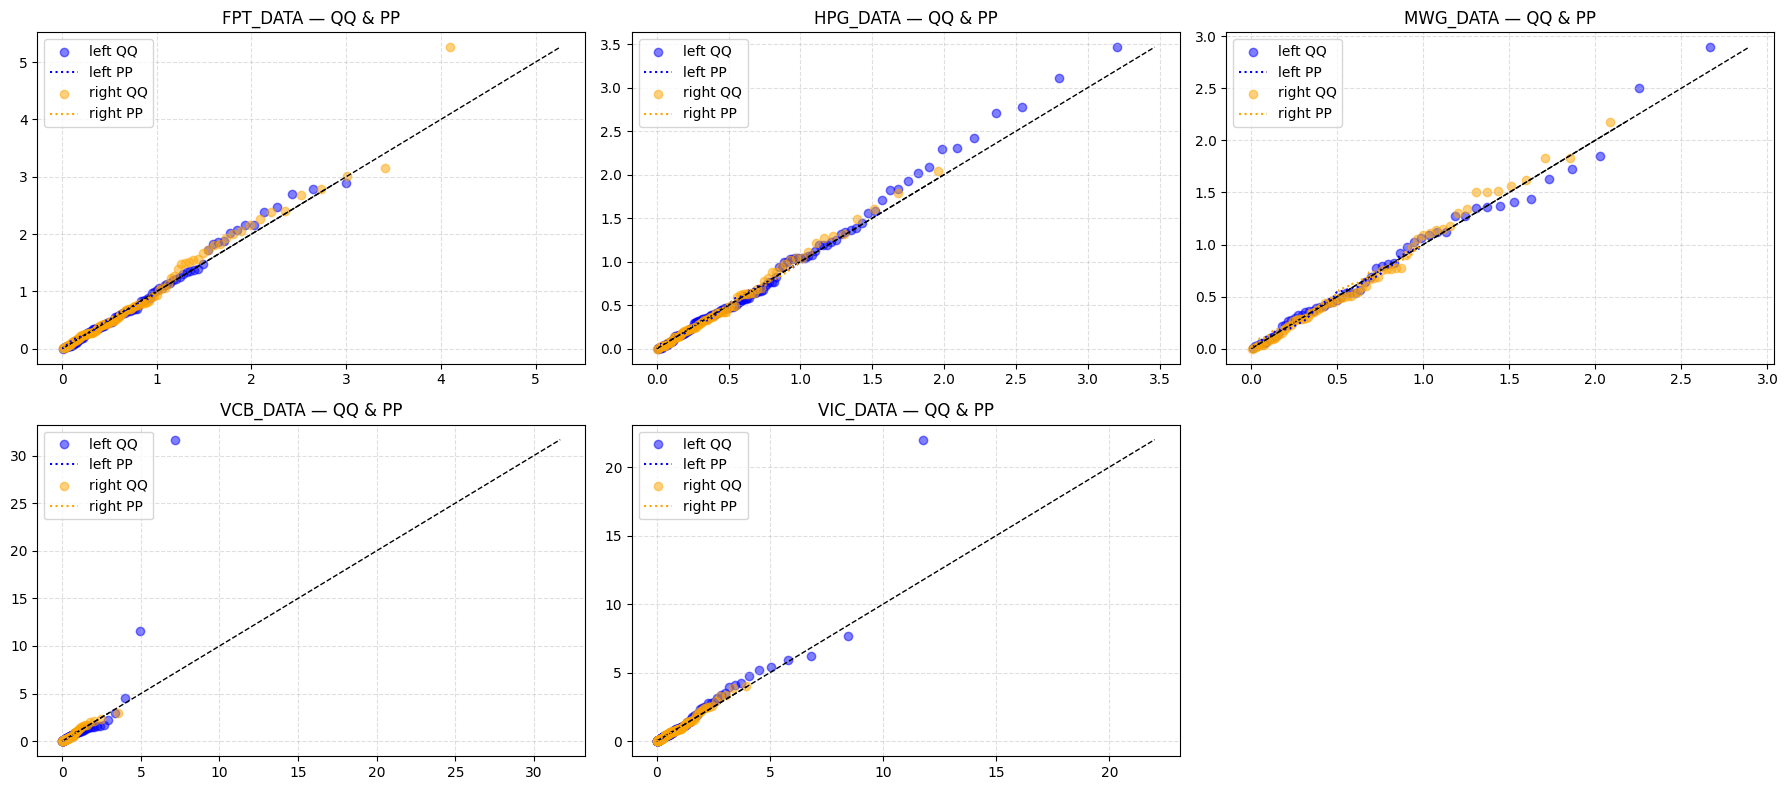

In [26]:
# Đường dẫn
std_resids = pd.read_csv("../models/garch/std_resids.csv", index_col=0)
at_best = pd.read_csv("../models/evt/evt_at_best.csv")

tickers = ["FPT_DATA","HPG_DATA","MWG_DATA","VCB_DATA","VIC_DATA"]
cols, rows = 3, int(np.ceil(len(tickers)/3))
fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
axes = axes.ravel()

for i, ticker in enumerate(tickers):
    ax = axes[i]
    for side,color in [("left","blue"),("right","orange")]:
        # lấy u* và dữ liệu exceedances
        m = (at_best["Ticker"]==ticker) & (at_best["Side"]==side)
        if not m.any(): continue
        u = at_best.loc[m,"u"].iloc[0]
        x = std_resids[ticker].dropna().values
        x = -x if side=="left" else x
        exc = x[x > u] - u
        if exc.size < 10: continue
        # fit GPD
        c,loc,s = genpareto.fit(exc, floc=0)
        # QQ-plot
        q_emp = np.sort(exc)
        q_theo = genpareto.ppf(np.linspace(0.01,0.99,len(exc)), c, 0, s)
        ax.scatter(q_theo, q_emp, alpha=0.5, label=f"{side} QQ", color=color)
        ax.plot([q_emp.min(),q_emp.max()],[q_emp.min(),q_emp.max()],'k--',lw=1)
        # PP-plot
        F_emp = np.arange(1,len(exc)+1)/ (len(exc)+1)
        F_theo = genpareto.cdf(q_emp, c, 0, s)
        ax.plot(F_theo, F_emp, linestyle=":", color=color, label=f"{side} PP")

    ax.set_title(f"{ticker} — QQ & PP")
    ax.legend(); ax.grid(True, ls="--", alpha=0.4)

for j in range(i+1,len(axes)): axes[j].axis("off")
plt.tight_layout(); plt.show()


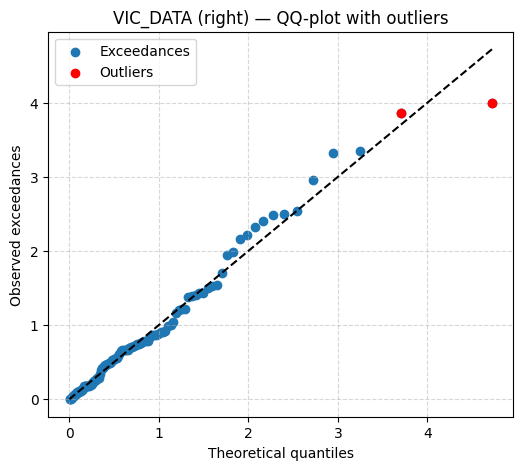

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import genpareto, zscore

# Load thresholds u* đã chọn
at_best = pd.read_csv("../models/evt/evt_at_best.csv")

ticker = "VIC_DATA"     # đổi mã khác ở đây
side   = "right"         # hoặc "right"

# Lấy threshold u*
row = at_best[(at_best["Ticker"] == ticker) & (at_best["Side"] == side)].iloc[0]
u = row["u"]

# Lấy dữ liệu exceedances
x = std_resids_df[ticker].dropna().values
x = -x if side == "left" else x
exc = x[x > u] - u

# Fit GPD
c, loc, s = genpareto.fit(exc, floc=0)

# QQ-plot
exc_sorted = np.sort(exc)
theo_q = genpareto.ppf((np.arange(1, len(exc)+1)-0.5)/len(exc), c, 0, s)

# Detect outliers by z-score
zs = zscore(exc_sorted)
out_idx = np.where(np.abs(zs) > 3)[0]

plt.figure(figsize=(6,5))
plt.scatter(theo_q, exc_sorted, label="Exceedances")
plt.scatter(theo_q[out_idx], exc_sorted[out_idx], color="red", label="Outliers", zorder=5)
plt.plot([0, theo_q.max()], [0, theo_q.max()], "k--")
plt.title(f"{ticker} ({side}) — QQ-plot with outliers")
plt.xlabel("Theoretical quantiles")
plt.ylabel("Observed exceedances")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


In [76]:
import os, numpy as np, pandas as pd

# ==== INPUT ====
PRICES_CSV = "../data/processed/price_cleaned.csv"   # file như bạn gửi: Date + cột ticker (giá Close)
OUT_AUDIT  = "../data/processed/audit_outliers.csv"

# Ngưỡng phát hiện outlier (log-return)
TH_ABS  = 0.1   # |ln(P_t/P_{t-1})| > 10% (đổi nếu cần)
SIGMA_K = 6      # hoặc |ret| > k*sigma rolling
SIGMA_WIN = 60

# ==== LOAD ====
prices = pd.read_csv(PRICES_CSV, parse_dates=[0], index_col=0).astype(float)
prices.index.name = "Date"

# ==== LOG-RETURNS & CANDIDATES ====
lr = np.log(prices / prices.shift(1))
vol = lr.rolling(SIGMA_WIN, min_periods=max(20, SIGMA_WIN//2)).std()
cand_mask = (lr.abs() > TH_ABS) | (lr.abs() > SIGMA_K * vol)
candidates = lr[cand_mask].stack().rename("ret").reset_index().rename(columns={"level_1":"Ticker"})
candidates = candidates.sort_values(["Ticker","Date"]).reset_index(drop=True)

# Thêm giá hôm trước và hôm nay để dễ đối chiếu
candidates["prev_price"] = np.nan
candidates["today_price"] = np.nan

for i, row in candidates.iterrows():
    ticker = row["Ticker"]
    date = row["Date"]
    
    if date in prices.index:
        loc = prices.index.get_loc(date)
        if loc > 0:  # Đảm bảo có giá hôm trước
            candidates.loc[i, "today_price"] = prices.loc[date, ticker]
            candidates.loc[i, "prev_price"] = prices.iloc[loc-1][ticker]

print(f"Found {len(candidates)} candidate outliers")
print("\nCandidate outliers with price info:")
print(candidates.head(20))

# Lưu danh sách outliers để kiểm tra thủ công
os.makedirs(os.path.dirname(OUT_AUDIT), exist_ok=True)
candidates.to_csv(OUT_AUDIT, index=False)
print(f"\nSaved candidate outliers to: {OUT_AUDIT}")


Found 7 candidate outliers

Candidate outliers with price info:
        Date    Ticker       ret  prev_price  today_price
0 2016-06-20  FPT_DATA  0.055370      8847.4       9351.1
1 2022-04-05  VCB_DATA -0.161537     82600.0      70279.0
2 2025-03-05  VCB_DATA -0.402132     93000.0      62207.0
3 2014-08-20  VIC_DATA -0.320206     41697.0      30272.0
4 2016-06-01  VIC_DATA -0.171748     38610.0      32517.0
5 2019-07-22  VIC_DATA -0.113478    116000.0     103556.0
6 2025-03-07  VIC_DATA  0.067339     42350.0      45300.0

Saved candidate outliers to: ../data/processed/audit_outliers.csv


In [ ]:
# ==== XỬ LÝ STOCK SPLITS - ĐIỀU CHỈNH GIÁ ====
# ⚠️ KHÔNG XÓA ngày split vì sẽ tạo jump giữa T-1 và T+1
# Thay vào đó: ĐIỀU CHỈNH tất cả giá TRƯỚC ngày split

stock_split_adjustments = [
    # Format: (ticker, date_string, split_ratio)
    # Ví dụ: ('VCB_DATA', '2025-03-05', 0.598),  # 10,647/17,800 = 0.598
    #        ('VIC_DATA', '2014-08-20', 0.680),  # 61,200/90,000 = 0.680
]

print("=== ADJUSTING STOCK SPLITS ===")
if stock_split_adjustments:
    # Load dữ liệu gốc
    prices_original = pd.read_csv(PRICES_CSV, parse_dates=[0], index_col=0).astype(float)
    prices_adjusted = prices_original.copy()
    
    for ticker, date_str, actual_ratio in stock_split_adjustments:
        split_date = pd.to_datetime(date_str)
        if split_date in prices_adjusted.index:
            # Điều chỉnh TẤT CẢ giá TRƯỚC ngày split
            before_mask = prices_adjusted.index < split_date
            prices_adjusted.loc[before_mask, ticker] *= actual_ratio
            
            print(f"Adjusted {ticker} prices before {date_str}")
            print(f"  Ratio used: {actual_ratio:.3f}")
            
            # Kiểm tra tính liên tục
            loc = prices_adjusted.index.get_loc(split_date)
            if loc > 0:
                p_before = prices_adjusted.iloc[loc-1][ticker]
                p_after = prices_adjusted.iloc[loc][ticker]
                new_ret = np.log(p_after / p_before)
                print(f"  New return on split day: {new_ret:.4f} ({new_ret*100:.2f}%)")
    
    # Lưu dữ liệu đã điều chỉnh
    prices_adjusted.to_csv("../data/processed/price_split_adjusted.csv")
    
    # Tính lại log returns
    lr_adjusted = np.log(prices_adjusted / prices_adjusted.shift(1)).dropna()
    lr_adjusted.to_csv("../data/processed/log_returns_split_adjusted.csv")
    print(f"\n✅ Split-adjusted data saved")
    print(f"Original: {len(prices_original)} days → Adjusted: {len(prices_adjusted)} days")
else:
    print("No split adjustments specified. Add them to stock_split_adjustments list above.")

## 6. Restart với dữ liệu đã làm sạch

**Sau khi xử lý stock splits, bạn cần:**

1. **Update đường dẫn input** ở section 2:
   - Đổi `"../data/processed/log_returns.csv"` → `"../data/processed/log_returns_no_splits.csv"`

2. **Chạy lại từ Section 3** (GARCH modeling):
   - `grid_search_marginal_model()` với dữ liệu mới
   - Tạo standardized residuals mới  
   - Re-fit EVT với residuals mới

3. **Backup kết quả cũ** (nếu cần):
   - Copy folder `models/garch/` → `models/garch_original/`
   - Copy folder `models/evt/` → `models/evt_original/`

**⚠️ Lưu ý:** Việc này sẽ mất ~5-10 phút để re-run toàn bộ modeling pipeline.

In [ ]:
# ==== HELPER: BACKUP & RESTART ====
import shutil

def backup_current_models():
    """Backup current model results before rerunning with clean data"""
    backup_dirs = {
        "../models/garch": "../models/garch_with_splits",
        "../models/evt": "../models/evt_with_splits"
    }
    
    for src, dst in backup_dirs.items():
        if os.path.exists(src):
            if os.path.exists(dst):
                shutil.rmtree(dst)
            shutil.copytree(src, dst)
            print(f"Backed up {src} → {dst}")

def use_clean_data():
    """Switch to split-adjusted data for remodeling"""
    global log_returns, log_returns_scaled
    
    clean_path = "../data/processed/log_returns_split_adjusted.csv"
    if os.path.exists(clean_path):
        log_returns = pd.read_csv(clean_path, index_col=0)
        log_returns_scaled = log_returns * 100
        print(f"✅ Switched to split-adjusted data: {log_returns.shape}")
        print("Now re-run from Section 3 (GARCH modeling)")
        return True
    else:
        print("❌ Split-adjusted data not found. Run stock split adjustment first.")
        return False

# Uncomment to backup current results and switch to clean data:
# backup_current_models()
# use_clean_data()

## 7. So sánh Approaches: Individual vs Unified Models

**Individual Models (Grid Search - Recommended):**
- ✅ Tối ưu cho từng ticker riêng biệt  
- ✅ Capture được heterogeneity giữa sectors
- ✅ Better diagnostic results
- ❌ Complexity trong management

**Unified Model Alternative:**
- ✅ Simplicity và consistency
- ✅ Easier interpretation  
- ❌ Có thể underfit cho individual assets
- ❌ Loss of ticker-specific information

**Recommendation: Stick với Grid Search results** vì:
1. Diverse asset classes cần different volatility modeling
2. Diagnostic tests cho thấy heterogeneity rõ ràng
3. EVT modeling sẽ benefit từ better standardized residuals

In [ ]:
# ==== EXPERIMENT: UNIFIED MODEL APPROACH ====
# Test single model specification for all tickers

def fit_unified_model(log_returns_scaled, model_spec):
    """
    Fit cùng 1 model specification cho tất cả tickers
    model_spec: tuple (p, d, q, vol_type, vol_p, vol_q, dist)
    """
    p, d, q, vol_type, vol_p, vol_q, dist = model_spec
    results = {}
    
    for ticker in log_returns_scaled.columns:
        try:
            y = log_returns_scaled[ticker].dropna()
            
            # ARIMA preprocessing (nếu cần)
            if p > 0 or q > 0 or d > 0:
                arima = SARIMAX(y, order=(p, d, q), trend='c' if d > 0 else None)
                arima_fit = arima.fit(disp=False)
                y_arima = arima_fit.resid
            else:
                arima_fit = None
                y_arima = y - y.mean()  # demean
            
            # GARCH fitting
            garch = arch_model(y_arima, vol=vol_type, p=vol_p, q=vol_q, dist=dist)
            garch_fit = garch.fit(disp='off', show_warning=False)
            
            # Save results
            results[ticker] = {
                'arima': arima_fit,
                'garch': garch_fit,
                'aic': garch_fit.aic,
                'std_resid': garch_fit.std_resid,
                'spec': model_spec
            }
            
        except Exception as e:
            print(f"Failed to fit {ticker}: {e}")
            continue
    
    return results

# Test with most common specification from grid search
# Majority voted: GARCH(1,1) with skewt distribution
common_spec = (0, 0, 0, 'GARCH', 1, 1, 'skewt')  # Simple GARCH(1,1)
print("Testing unified model: GARCH(1,1) with Skew-t distribution...")

unified_models = fit_unified_model(log_returns_scaled, common_spec)

# Compare AIC with individual models
comparison = []
for ticker in log_returns_scaled.columns:
    if ticker in models and ticker in unified_models:
        individual_aic = models[ticker]['aic']
        unified_aic = unified_models[ticker]['aic']
        comparison.append({
            'Ticker': ticker,
            'Individual_AIC': individual_aic,
            'Unified_AIC': unified_aic,
            'AIC_Diff': unified_aic - individual_aic,  # Positive = unified worse
            'Individual_Spec': f"ARIMA({models[ticker]['p']},{models[ticker]['d']},{models[ticker]['q']})-GARCH({models[ticker].get('vol_p',1)},{models[ticker].get('vol_q',1)})-{models[ticker]['dist']}",
            'Unified_Spec': f"ARIMA({common_spec[0]},{common_spec[1]},{common_spec[2]})-GARCH({common_spec[4]},{common_spec[5]})-{common_spec[6]}"
        })

comparison_df = pd.DataFrame(comparison)
print("\n=== AIC COMPARISON: Individual vs Unified Models ===")
print(comparison_df.round(2))

In [ ]:
# Diagnostic comparison
def quick_diagnostics(std_resids_dict, model_name=""):
    """Quick ARCH & Ljung-Box tests for model comparison"""
    results = []
    
    for ticker, resids in std_resids_dict.items():
        if resids is None:
            continue
            
        r = pd.Series(resids).dropna()
        
        # ARCH test
        try:
            arch_stat, arch_p, _, _ = het_arch(r)
        except:
            arch_p = np.nan
            
        # Ljung-Box test
        try:
            lb_result = acorr_ljungbox(r, lags=[10], return_df=True)
            lb_p = lb_result['lb_pvalue'].iloc[0]
        except:
            lb_p = np.nan
            
        results.append({
            'Model': model_name,
            'Ticker': ticker,
            'ARCH_p': arch_p,
            'LjungBox_p': lb_p,
            'Diagnostic_Score': (arch_p if not np.isnan(arch_p) else 0) + (lb_p if not np.isnan(lb_p) else 0)
        })
    
    return pd.DataFrame(results)

# Compare diagnostics
individual_std_resids = {k: v['std_resid'] for k, v in models.items()}
unified_std_resids = {k: v['std_resid'] for k, v in unified_models.items()}

print("\n=== DIAGNOSTIC COMPARISON ===")

individual_diag = quick_diagnostics(individual_std_resids, "Individual")
unified_diag = quick_diagnostics(unified_std_resids, "Unified")

all_diag = pd.concat([individual_diag, unified_diag]).pivot(
    index='Ticker', columns='Model', values=['ARCH_p', 'LjungBox_p', 'Diagnostic_Score']
)

print("ARCH p-values (higher is better):")
print(all_diag['ARCH_p'].round(3))
print("\nLjung-Box p-values (higher is better):")  
print(all_diag['LjungBox_p'].round(3))
print("\nDiagnostic Score (sum of p-values, higher is better):")
print(all_diag['Diagnostic_Score'].round(3))

In [ ]:
# Final recommendation based on results
print("\n" + "="*60)
print("FINAL RECOMMENDATION")
print("="*60)

# Count winners
individual_better_aic = (comparison_df['AIC_Diff'] < 0).sum()
individual_better_diag = (all_diag['Diagnostic_Score']['Individual'] > all_diag['Diagnostic_Score']['Unified']).sum()

print(f"AIC Comparison:")
print(f"  - Individual models better: {individual_better_aic}/{len(comparison_df)}")
print(f"  - Average AIC improvement: {comparison_df['AIC_Diff'].mean():.2f}")

print(f"\nDiagnostic Comparison:")
print(f"  - Individual models better: {individual_better_diag}/{len(all_diag)}")

# Decision logic
if individual_better_aic >= 3 and individual_better_diag >= 3:
    recommendation = "✅ RECOMMEND: Keep Individual Models (Grid Search Results)"
    reasoning = [
        "• Individual models outperform in both AIC and diagnostics",
        "• Heterogeneity across tickers is significant", 
        "• Better standardized residuals → Better EVT modeling",
        "• Each sector (Banking/Tech/Steel/Real Estate/Retail) has distinct patterns"
    ]
elif individual_better_aic <= 2 and individual_better_diag <= 2:
    recommendation = "✅ RECOMMEND: Use Unified Model (Simpler Approach)"
    reasoning = [
        "• Unified model performs competitively",
        "• Simplicity and maintainability benefits",
        "• Less overfitting risk",
        "• Easier to interpret and validate"
    ]
else:
    recommendation = "⚖️ MIXED RESULTS: Evaluate case-by-case"
    reasoning = [
        "• Some tickers benefit from individual modeling",
        "• Others are adequately captured by unified approach",
        "• Consider hybrid: unified for similar tickers, individual for outliers"
    ]

print(f"\n{recommendation}")
for reason in reasoning:
    print(f"  {reason}")

print(f"\n💡 For COPULA modeling: Individual models recommended")
print(f"   → Better marginal distributions = Better copula fitting")